In [3]:
import numpy as np
from scipy.optimize import least_squares
from scipy.ndimage import zoom
from scipy.signal import convolve2d
import h5py as h5
from pathlib import Path
import numpy as np
import math
import os
import matplotlib.pyplot as plt


def open_files(data_dir):
    data_list = list()
    f_list = os.listdir(data_dir)
    for f_name in f_list:
        try:
            f_address = data_dir / f_name
            f = h5.File(f_address, 'r')
            data_list.append(f[list(f.keys())[0]])
            # f.close()
        except:
            print(f"unable to open {f_name}")
    return data_list, f_list

def filtered_average_widefield(raw_data, period_0, filter_size=0):
    # create average widefield frame
    wf = np.sum(raw_data, axis=0)
    wf = np.double(wf)
    if filter_size==0:
        filter_size = np.mean(period_0)
    wf = wavelet_filter(wf, size=filter_size)
    # normalize 0-1
    wf -= np.min(wf)
    wf /= np.max(wf)
    return wf

def wavelet_filter(wf, size):
    """Perform a simple band-pass with a wavelet like kernel"""
    N = np.round(size)
    x = np.arange(-N,N+1)[None,:]
    y = np.arange(-N,N+1)[:,None]
    r = np.sqrt(x**2 + y**2)
    wavelet = np.cos(4*r/size) * np.exp(-r**2/(2*(0.6534*size/2)**2))
    wf_filtered = convolve2d(wf, wavelet, boundary='symm', mode='same')
    return wf_filtered

# Function for inner operations

def _complex_pattern(period, shape):
    x = np.arange(shape[0])[None,:]
    y = np.arange(shape[1])[:,None]
    i2pi = 1j*2*np.pi
    pattern_x = np.exp(i2pi*x/period[0]) * np.ones(y.shape)
    pattern_y = np.exp(i2pi*y/period[1]) * np.ones(x.shape)
    pattern_stack = np.stack((pattern_x, pattern_y))
    return pattern_stack

def _variable_projection_amplitude(wf, patterns):
    # NOTE: if optimizaiton is needed p_vec and wf_vec could be precomputed
    # this uses some linear algebra to solve linear fitting of phase and amplitude
    p_vec = np.reshape(patterns, [patterns.shape[0], wf.shape[0]*wf.shape[1]])
    wf_vec = wf.flatten()
    complex_amplitude = np.matmul(wf_vec, np.linalg.pinv(p_vec))
    return complex_amplitude

def pattern_model(wf, period):
    p = _complex_pattern(period, wf.shape)
    complex_amplitude = _variable_projection_amplitude(wf, p)
    model = np.einsum('i,ijk->jk', complex_amplitude, p).real
    return model

def pattern_amplitude_phase(wf, period):
    p = _complex_pattern(period, wf.shape)
    complex_amplitude = _variable_projection_amplitude(wf, p)
    phase = np.angle(complex_amplitude)/(2*np.pi)
    phase[phase<0] += 1 # make sure values between 0 and 1
    amplitude = np.abs(complex_amplitude)
    return amplitude, phase


def fit_pattern(wf, period_0):
    # fit model pattern
    residuals = lambda period: (wf - pattern_model(wf, period)).flatten()
    fit = least_squares(residuals, period_0)
    period = fit.x
    amplitude, phase = pattern_amplitude_phase(wf, period)
    return period, phase

def localize_pattern(raw_data, period_0, filter_size=0):
    wf = filtered_average_widefield(raw_data, period_0, filter_size)
    period, phase = fit_pattern(wf, period_0)
    return period, phase

def create_control_image(wf, period, zoom_factor=4):
    # generate control image for pattern
    model = pattern_model(wf, period)
    amplitude, _ = pattern_amplitude_phase(wf, period)
    model_normalized = (model/amplitude.sum() + 1)/2
    model_zoom = zoom(model_normalized, zoom=zoom_factor)
    wf_zoom = zoom(wf, zoom=zoom_factor)
    wf_zoom = (wf_zoom - np.min(wf_zoom))/(np.max(wf_zoom) - np.min(wf_zoom))
    dots = model_zoom**12
    control_image = wf_zoom * (1-dots)
    return control_image, dots

unable to open c2.tif
[<HDF5 dataset "CAM": shape (576, 560, 560), type "<i2">]
(576, 560, 560)
24.0


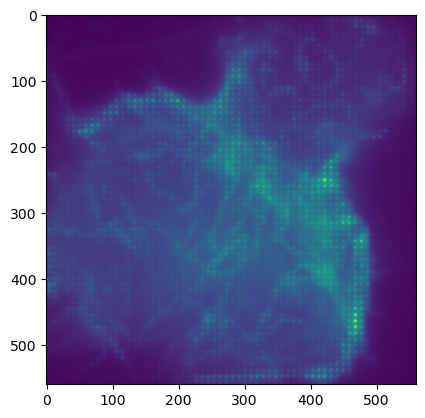

In [4]:
data_dir = Path("/mnt/efs/shared_data/restorators/monalisa_data/FullStackHandlingTry")
filename = "_rec_scan00_CAM.hdf5"
data_list, f_list = open_files(data_dir)
print(data_list)
stack=np.array(data_list[0])
print(stack.shape)
print(math.sqrt(stack.shape[0]))
plt.imshow(np.sum(stack,axis=0))
plt.show()

In [4]:
period, phase = localize_pattern(stack, [9.27,9.27],3)

[9.27981016 9.2626927 ] [0.62189988 0.91201958]


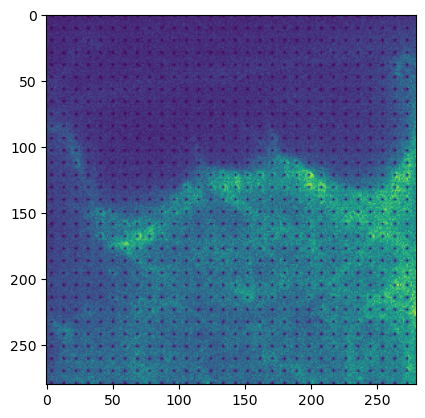

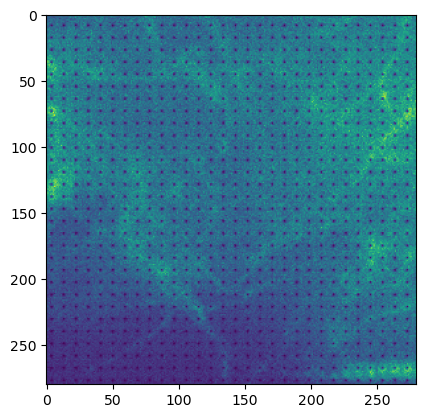

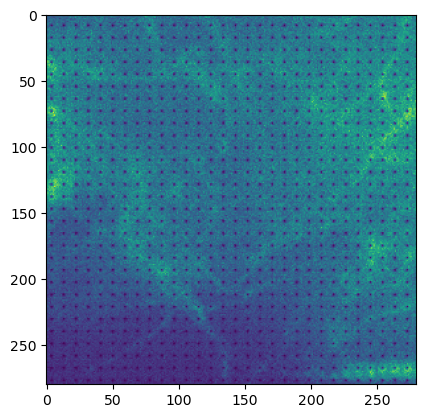

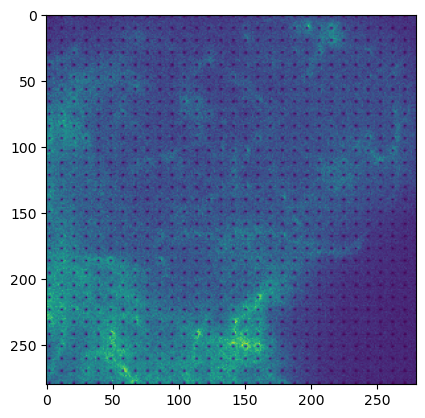

In [5]:
print(period,phase)

control,dots = create_control_image(stack[0,...], period, zoom_factor=1)
plt.figure()
plt.imshow(control[:280,:280])
plt.figure()
plt.imshow(control[280:560,:280])
plt.figure()
plt.imshow(control[280:560,:280])
plt.figure()
plt.imshow(control[:280,280:560])
plt.show()

(560, 560)


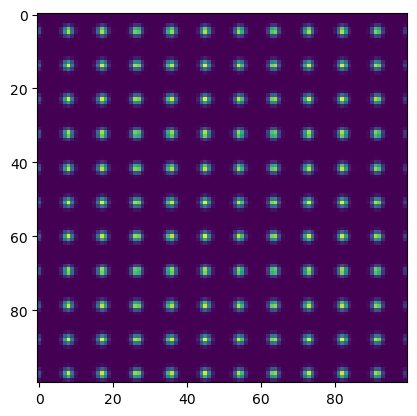

In [6]:
print(dots.shape)
plt.figure
plt.imshow(dots[200:300,200:300])
plt.show()

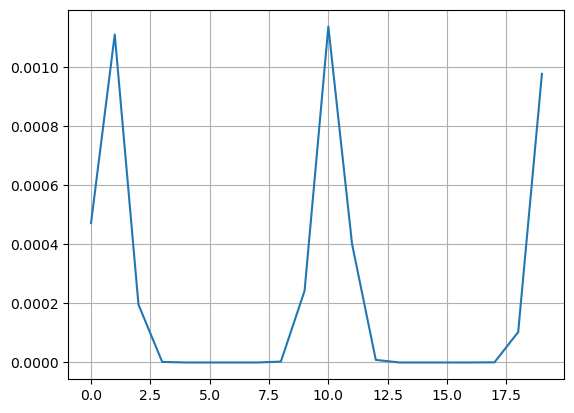

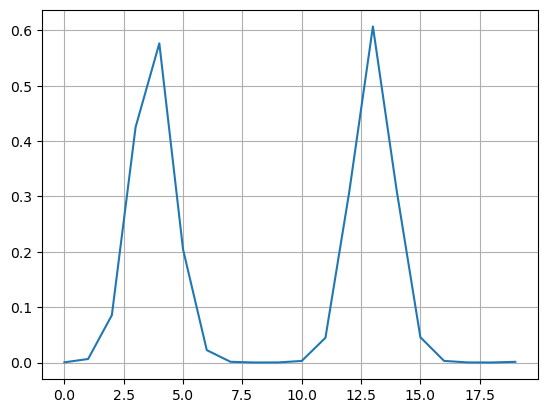

In [7]:
x=np.linspace(0,559,560)
#print(x)
plt.figure()
plt.plot(x[:20],dots[0:20,0])
plt.grid()
plt.figure()
plt.plot(x[:20],dots[0,:20])
#plt.plot(x[:20],np.cos(2*math.pi*x[:20]/period[1] + phase[1]+math.pi)*0.5)
plt.grid()
plt.show()

In [8]:
print(phase[1])
print(period[1]*(1 - phase[1]))

0.9120195763690039
0.8149356281435164


In [9]:
xc_0 = period[0]*(1 - phase[0])
yc_0 = period[1]*(1 - phase[1])

print(xc_0, yc_0)

13 10


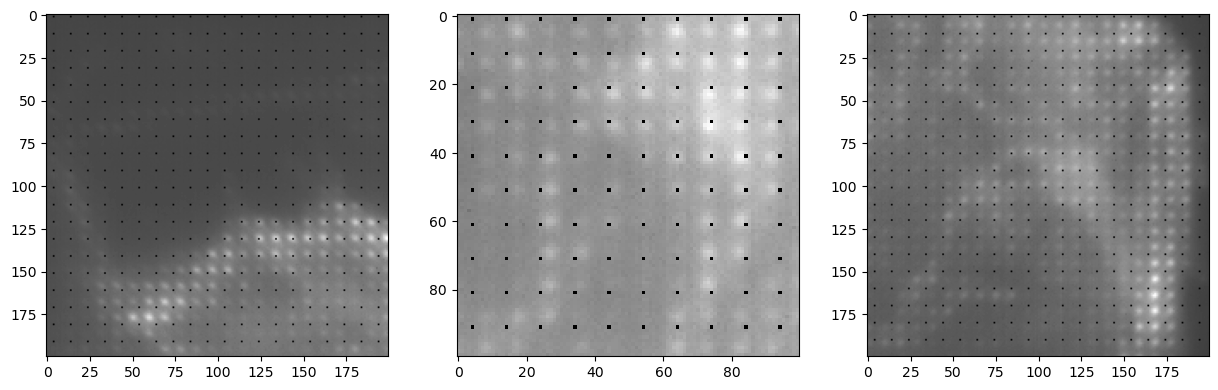

In [45]:
x0 = xc_0 #+ period[0]/2
y0 = yc_0 #+ period[1]/2

img = np.sum(stack,axis=0)
img_2 = img.copy()

c_9=0
c_10=0
c_11=0

idx_x = x0
idx_y = y0
while idx_x < 560:
    while idx_y < 560:
        dx = round(idx_x + period[0]) - round(idx_x)
        if dx == 10:
            c_10+=1
        if dx == 9:
            c_9 += 1
        if dx ==11:
            c_11 += 1
        img_2[round(idx_y),round(idx_x)]=0
        idx_y += period[1]
    idx_y = y0
    idx_x += period[0]
print

a = 200
b = 300
c = 500

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(img_2[:a,:a],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img_2[a:b,a:b],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(img_2[b:c,b:c],cmap='gray')
plt.show()

In [19]:
stack_4d = np.reshape(stack,[24,24,560,560])
stack_4d_proj_1 = np.sum(stack_4d, axis=0)
stack_4d_proj_2 = np.sum(stack_4d, axis=1)

"""
for i in range (24):
    plt.figure()
    plt.imshow(stack_4d_proj[i][300:350,300:350])
    plt.show()
    """

'\nfor i in range (24):\n    plt.figure()\n    plt.imshow(stack_4d_proj[i][300:350,300:350])\n    plt.show()\n    '

In [5]:
from tifffile import imsave

#imsave("stack_proj_2.tiff",stack_4d_proj_2.astype(np.float32),imagej=True)

In [23]:
stack_4d = np.reshape(stack,[24,24,560,560])
stack_4d_swapped = np.flip(stack_4d, axis=1)
#stack_4d_swapped=np.transpose(stack_4d, [1,0,2,3])
stack_4d_proj_x = np.sum(stack_4d_swapped, axis=0)
stack_4d_proj_y = np.sum(stack_4d_swapped, axis=1)

imsave("stack_proj_x.tiff",stack_4d_proj_x.astype(np.float32),imagej=True)
imsave("stack_proj_y.tiff",stack_4d_proj_y.astype(np.float32),imagej=True)

/tmp/ipykernel_4905/2406568420.py:7: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave("stack_proj_x.tiff",stack_4d_proj_x.astype(np.float32),imagej=True)
/tmp/ipykernel_4905/2406568420.py:8: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave("stack_proj_y.tiff",stack_4d_proj_y.astype(np.float32),imagej=True)


In [ ]:
stack_6d = np.zeros(shape=(24,24,60,60,9,9))

In [6]:
import cv2 as cv

stack_resize=np.zeros([576,604,604])
for i in range(576):
    stack_resize[i,...] = cv.resize(stack[i],(604,604))



In [7]:
period, phase = localize_pattern(stack_resize, [10,10],3)
print(period)
print(stack_resize.shape)

[10.0086597   9.99133491]
(576, 604, 604)


In [43]:
xc_0 = period[0]*(1 - phase[0])
yc_0 = period[1]*(1 - phase[1])
print(xc_0,yc_0)

3.8940645332695722 0.8566381332068991


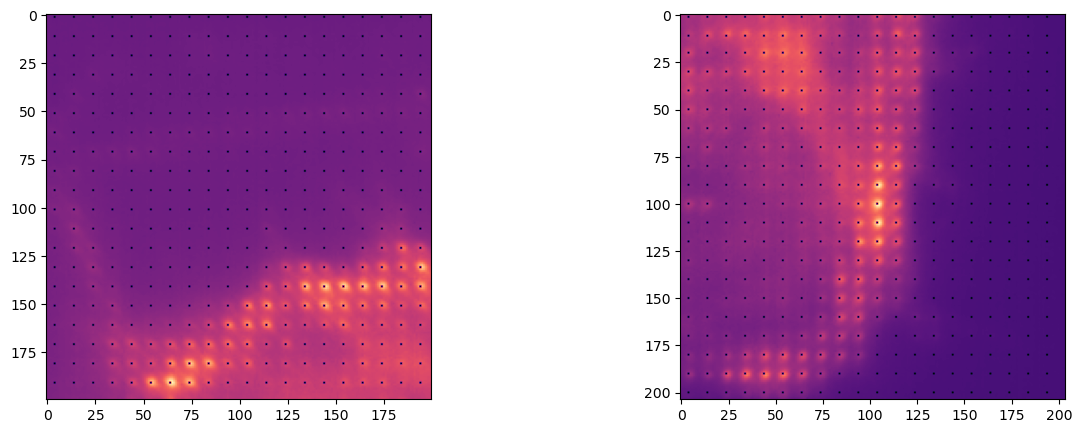

In [8]:
xc_0 = period[0]*(1 - phase[0])
yc_0 = period[1]*(1 - phase[1])

x0 = xc_0 #+ period[0]/2
y0 = yc_0 #+ period[1]/2

img = np.sum(stack_resize,axis=0)
img_2 = img.copy()

c_9=0
c_10=0
c_11=0

idx_x = x0
idx_y = y0
while idx_x < 604:
    while idx_y < 604:
        dx = round(idx_x + period[0]) - round(idx_x)
        if dx == 10:
            c_10+=1
        if dx == 9:
            c_9 += 1
        if dx ==11:
            c_11 += 1
        img_2[round(idx_y),round(idx_x)]=0
        idx_y += period[1]
    idx_y = y0
    idx_x += period[0]

a = 200

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(img_2[:a,:a],cmap='magma')
plt.subplot(1,2,2)
plt.imshow(img_2[400:604,400:604],cmap='magma')
plt.show()

In [9]:
stack_4d_r = np.reshape(stack_resize,[24,24,604,604])
stack_4d_r_xflip = np.flip(stack_4d_r, axis=1)
#stack_4d_swapped=np.transpose(stack_4d, [1,0,2,3])
stack_4d_r_xflip_proj_x = np.sum(stack_4d_r_xflip, axis=0)
stack_4d_r_xflip_proj_y = np.sum(stack_4d_r_xflip, axis=1)

imsave("stack_proj_r_x.tiff",stack_4d_r_xflip_proj_x.astype(np.float32),imagej=True)
imsave("stack_proj_r_y.tiff",stack_4d_r_xflip_proj_y.astype(np.float32),imagej=True)

/tmp/ipykernel_12619/1983215420.py:7: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave("stack_proj_r_x.tiff",stack_4d_r_xflip_proj_x.astype(np.float32),imagej=True)
/tmp/ipykernel_12619/1983215420.py:8: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave("stack_proj_r_y.tiff",stack_4d_r_xflip_proj_y.astype(np.float32),imagej=True)


In [10]:
stack_6d = np.zeros(shape=(24,24,59,59,10,10))
p = 10

xc_0 = period[0]*(1 - phase[0])
yc_0 = period[1]*(1 - phase[1])

x0 = round(xc_0 + period[0]/2)
y0 = round(yc_0 + period[1]/2)

for i in range(24):
    for j in range(24):

        idx_x = x0
        idx_y = y0
        slice = stack_4d_r_xflip[i,j,...]
        while idx_x <= 604 - p:
            while idx_y <= 604 - p:
                stack_6d[i,j,(idx_y-y0)//p,(idx_x-x0)//p,...]=slice[idx_y:idx_y+p,idx_x:idx_x + p]
                idx_y += p
                #print(idx_y)
            #print('out')
            idx_y = y0
            idx_x += p



[[112. 111. 110. 115. 115. 120. 119. 116. 114. 113.]
 [113. 119. 126. 119. 122. 116. 116. 118. 113. 112.]
 [119. 109. 107. 116. 119. 113. 110. 113. 113. 112.]
 [120. 110.  93. 146. 149. 126. 118. 120. 114. 110.]
 [119. 115. 101. 127. 135. 131. 135. 139. 125. 112.]
 [103. 113. 110. 121. 145. 148. 140. 140. 126. 112.]
 [124. 126. 113. 115. 122. 135. 140. 139. 137. 125.]
 [119. 116. 114. 132. 130. 130. 141. 144. 138. 130.]
 [120. 115. 121. 129. 116. 118. 130. 131. 130. 137.]
 [115. 110. 117. 118. 108. 119. 118. 122. 135. 145.]]


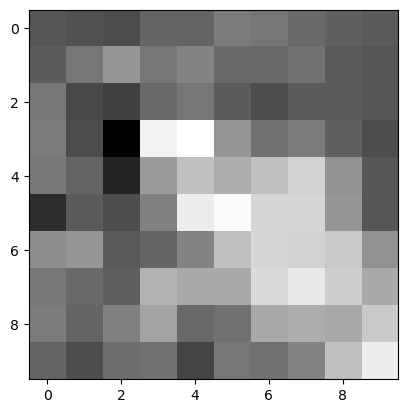

In [72]:
idx_scan_x = 5
idx_scan_y = 5
ulens_x = 10
ulens_y = 10

ulens_patch = stack_6d[idx_scan_y,idx_scan_x,ulens_y,ulens_x,...]
print(ulens_patch)

plt.figure()
plt.imshow(ulens_patch,cmap='gray')
plt.show()

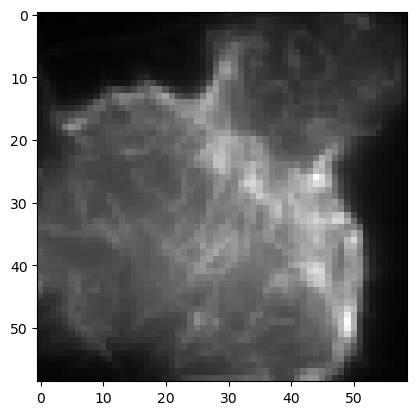

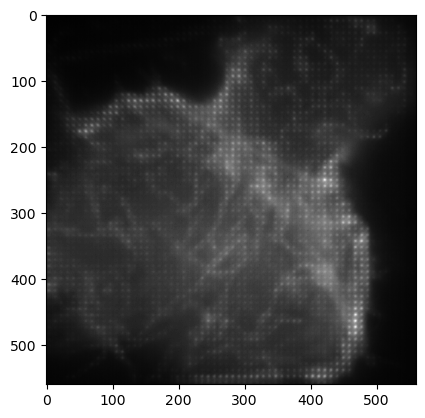

In [11]:


img_proj = stack_6d.mean(axis=(0,1,4,5))

plt.figure()
plt.imshow(img_proj,cmap='gray')
plt.show()
plt.figure()
plt.imshow(np.sum(stack,axis=0),cmap='gray')
plt.show()

In [12]:
stack_6d_flip = np.flip(stack_6d,(0,1))
stack_6d_swapped = np.transpose(stack_6d_flip,(2,0,3,1,4,5))
new_stack_4d_1 = np.reshape(stack_6d_swapped,[24*59,24,59,10,10])
new_stack_4d_2 = np.reshape(new_stack_4d_1,[24*59,24*59,10,10])
print(new_stack_4d_2.shape)

(1416, 1416, 10, 10)


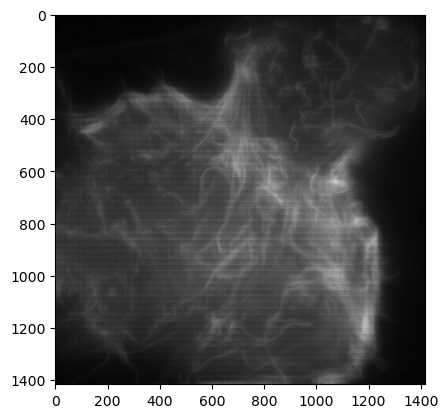

In [13]:
img_try = new_stack_4d_2.mean(axis=(2,3))
plt.figure()
plt.imshow(img_try,cmap='gray')
plt.show()


In [77]:
imsave("image_noshift_uint8.tiff",new_stack_4d_2[:,400:800,400:800].astype(np.uint8))

/tmp/ipykernel_12619/2252497931.py:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave("image_noshift_uint8.tiff",new_stack_4d_2[:,400:800,400:800].astype(np.uint8))
/home/guillaumem/conda/envs/good_env/lib/python3.10/site-packages/tifffile/tifffile.py:2140: UserWarning: <tifffile.TiffWriter 'image_noshift_uint8.tiff'> writing zero-size array to nonconformant TIFF
  warnings.warn(


In [78]:
stack_4d_shifted = np.zeros_like(new_stack_4d_2)
f = 0

for x in range(10):
    for y in range(10):
        
        sx = round(x*f)
        sy = round(y*f)
        print(sx,sy)
        stack_4d_shifted[sy:,sx:,y,x]=new_stack_4d_2[:1416-sy,:1416-sx,y,x]


0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


In [56]:
print(stack_4d_shifted.shape)

(1416, 1416, 10, 10)


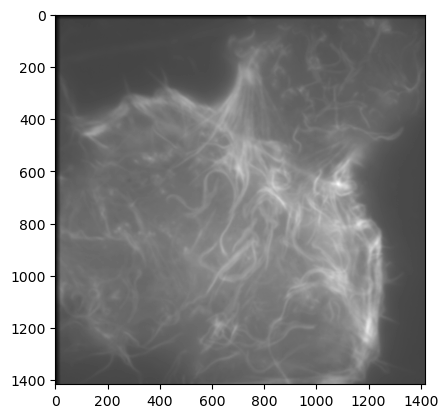

In [57]:
img_try_2 = stack_4d_shifted.mean(axis=(2,3))
plt.figure()
plt.imshow(img_try_2,cmap='gray')
plt.show()


In [79]:
final_stack = np.reshape(stack_4d_shifted,(1416,1416,100))
final_stack_swapped = np.transpose(final_stack,(2,0,1))
print(final_stack_swapped.shape)
#imsave("image.tiff",final_stack_swapped)
final_stack_swapped_norm = 255* final_stack_swapped/np.max(final_stack_swapped)
imsave("image_noshift_uint8.tiff",final_stack_swapped_norm[:,400:800,400:800].astype(np.uint8))

(100, 1416, 1416)


/tmp/ipykernel_12619/2727077125.py:6: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave("image_noshift_uint8.tiff",final_stack_swapped_norm[:,400:800,400:800].astype(np.uint8))


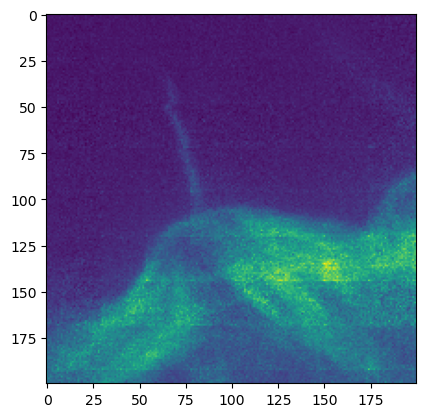

In [60]:
plt.figure()
plt.imshow(final_stack_swapped[46,200:400,200:400])
plt.show()

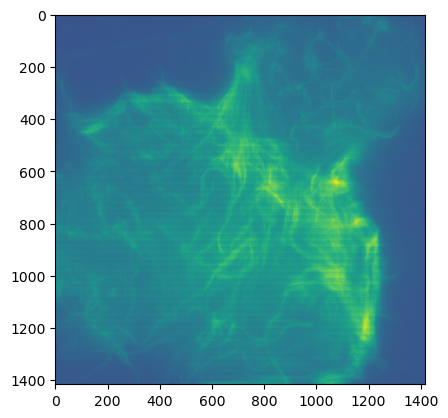

In [27]:
plt.figure()
plt.imshow(final_stack_swapped.mean(axis=0))
plt.show()

In [1]:
final_stack_norm = 255*final_stack / np.max(final_stack)
imsave("image_uint8.tiff",final_stack_norm.astype(np.uint8),imagej=True)


NameError: name 'final_stack' is not defined